### import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [2]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

### Download nltk data

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/snehil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/snehil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/snehil/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/snehil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/snehil/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/snehil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Download the data

In [4]:
# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
# !wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

# Data at : DataVault/02_lazy_programmer_nlp

### Read the data

In [5]:
df = pd.read_csv("/home/snehil/work/DataVault/02_lazy_programmer_nlp/bbc_text_cls.csv")

In [6]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [7]:
inputs = df['text']
labels = df['labels']

<Axes: >

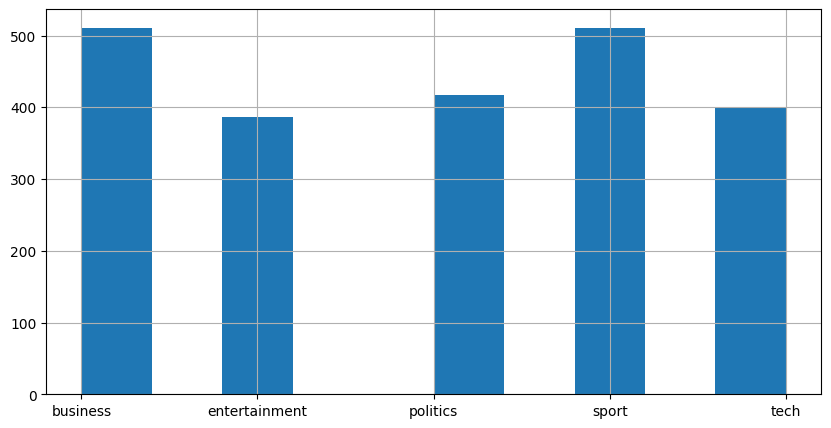

In [8]:
labels.hist(figsize=(10, 5))

### train test split

In [9]:
inputs_train, inputs_test, Ytrain, Ytest = train_test_split(inputs, labels, random_state=123)

### instantiate countvectorizer

In [10]:
vectorizer = CountVectorizer()

Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

In [13]:
Xtrain.shape

(1668, 26287)

In [14]:
Xtrain

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 337411 stored elements and shape (1668, 26287)>

In [15]:
# what percentage of values are non-zero
print("Percentage of non-zero values in Xtrain: ", (Xtrain != 0).sum() / np.prod(Xtrain.shape))

Percentage of non-zero values in Xtrain:  0.007695239935415004


#### re-verify output

In [16]:
(Xtrain != 0).sum()

np.int64(337411)

In [17]:
(Xtrain == 0).sum()

/home/snehil/.dev_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


np.int64(43509305)

In [18]:
(Xtrain != 0).sum()/((Xtrain != 0).sum()+(Xtrain == 0).sum())

np.float64(0.007695239935415004)

### Usual machine learning steps

In [19]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("Train accuracy: ", model.score(Xtrain, Ytrain))
print("Test accuracy: ", model.score(Xtest, Ytest))

Train accuracy:  0.9922062350119905
Test accuracy:  0.9712746858168761


In [20]:
# with stopwords
vectorizer = CountVectorizer(stop_words='english')
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("Train accuracy: ", model.score(Xtrain, Ytrain))
print("Test accuracy: ", model.score(Xtest, Ytest))

Train accuracy:  0.9928057553956835
Test accuracy:  0.9766606822262118


In [21]:
Xtrain.shape # less width of vector , in line with stop words removing commonly used words

(1668, 25995)

#### using lemmatization

In [22]:
# pos tagging
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN
  
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags]

In [23]:
# with lemmatization
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/home/snehil/.dev_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9922062350119905
test score: 0.9676840215439856


In [27]:
Xtrain.shape

(1668, 25894)

#### with stemming

In [28]:
class StemTokenizer:
  def __init__(self):
    self.porter = PorterStemmer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    return [self.porter.stem(t) for t in tokens]

In [29]:
vectorizer = CountVectorizer(tokenizer=StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/home/snehil/.dev_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9892086330935251
test score: 0.9694793536804309


In [30]:
Xtrain.shape

(1668, 22714)

#### Using string split

In [31]:
def simple_tokenizer(s):
  return s.split()

In [32]:
# with string split
vectorizer = CountVectorizer(tokenizer=simple_tokenizer)
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/home/snehil/.dev_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9952038369304557
test score: 0.9712746858168761


In [33]:
Xtrain.shape

(1668, 52144)

In [34]:
# What is the vector dimensionality in each case?
# Compare them and consider why they are larger / smaller